# Potential flow around a rotating cylinder

Philipp Schlatter, 2024 (adapted from Barba et al. Aeropython)

Import necessary libraries:

In [98]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
# embed the figures into the notebook
#%matplotlib notebook
%matplotlib inline

Cylinder parameter:

In [99]:
x_center, y_center = 0.0, 0.0
u_inf = 1            
R = 1
Gamma = -4

Define the strength of the doublet/dipole such that we get a cylinder with radius $R$

In [100]:
M = (R**2)*2*np.pi*u_inf  # doublet for circle with radius R

Definition of the mesh. You can use either Cartesian or polar coordinates:

In [101]:
class Cartesian:
    def __init__(self,N,x_start,x_end,y_start,y_end):
        self.X, self.Y = np.meshgrid(np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N))
        self.type = "Cartesian"
        
class Polar:
    def __init__(self,N,r_start,r_end):
        xx,yy = np.meshgrid(np.linspace(r_start,r_end,N),np.linspace(0,2*np.pi,N,endpoint=True))
        self.X, self.Y = xx*np.cos(yy)+x_center,xx*np.sin(yy)+y_center
        self.phi = yy
        self.type = "Polar"
        
class Velocity:
    def __init__(self,mesh):
        self.u = mesh.X*0
        self.v = mesh.X*0
        self.p = mesh.X*0
        
    def comp_p(self,u_ref):
        self.p = 2*(0.5*u_ref**2-0.5*(self.u**2 + self.v**2))

In [113]:
mesh = Cartesian(100,-8,8,-8,8)    # for streamplot
#mesh = Polar(100,R,5*R)            # for cp(phi) curve

Definition of the basic potential flow solutions. Eventually one could add the velocity potential $\phi$ as well.

In [114]:
class Doublet:
    # strength M
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y
        
    def vel(self, mesh):
        u = (-self.strength / (2 * np.pi) *
             ((mesh.X - self.x)**2 - (mesh.Y - self.y)**2) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        v = (-self.strength / (2 * np.pi) *
             2 * (mesh.X - self.x) * (mesh.Y - self.y) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        return u, v
            
    def psi(self, mesh):
        psi = (self.strength / (2 * np.pi) *
               (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return psi

In [115]:
class Vortex:
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y
    
    def vel(self, mesh):
        u = -self.strength / (2 * np.pi) * (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        v = +self.strength / (2 * np.pi) * (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return u, v
    
    def psi(self, mesh):
        psi =  self.strength / (4 * np.pi) * np.log((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return psi

In [116]:
class Source:
    # m=Q/2pi
    def __init__(self, strength, x, y):
        self.strength = strength  # Q
        self.x, self.y = x, y
    
    def vel(self, mesh):
        u = (self.strength / (2 * np.pi) *
             (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        v = (self.strength / (2 * np.pi) *
             (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return u, v
    
    def psi(self, mesh):
        psi = -(self.strength / (2 * np.pi) *
               numpy.arctan2((mesh.Y - self.y), (mesh.X - self.x)))
        return psi

In [117]:
class Freestream:
    def __init__(self, strength, alpha):
        self.strength = strength
        self.alpha = alpha
        
    def vel(self, mesh):
        u = mesh.X*0 + self.strength*np.cos(self.alpha) 
        v = mesh.X*0 + self.strength*np.sin(self.alpha) 
        return u, v
            
    def psi(self, mesh):
        psi = self.strength*(mesh.X*np.sin(self.alpha) - mesh.Y*np.cos(self.alpha))
        return psi

Compute the solution solution:

In [118]:
# Flow around a cylinder
fst = Freestream(u_inf,0)
u1,v1 = fst.vel(mesh)
psi1 = fst.psi(mesh)

doublet = Doublet(strength=M, x=x_center,y=y_center)
u2, v2 = doublet.vel(mesh)
psi2 = doublet.psi(mesh)

vortex = Vortex(strength=Gamma, x=x_center,y=y_center)
u3, v3 = vortex.vel(mesh)
psi3 = vortex.psi(mesh)

U = Velocity(mesh)
U.u = u1+u2+u3
U.v = v1+v2+v3
psi = psi1+psi2+psi3

# R = np.sqrt(M/(2*np.pi*u_inf))

theta = np.linspace(0.0, 2 * np.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

### Plot the velocity and pressure solutions:

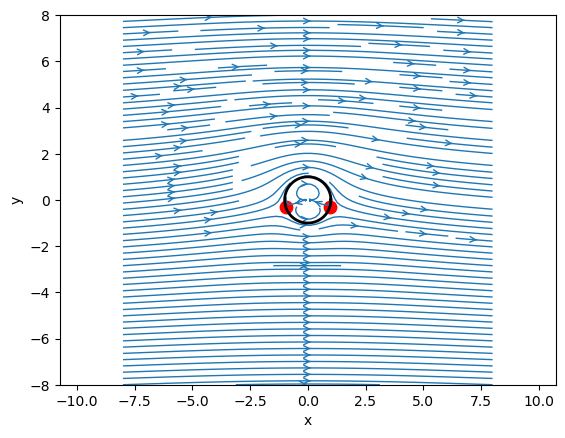

In [119]:
# streamplot. Works only for Cartesian grids
if mesh.type=="Cartesian":
    plt.figure()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.streamplot(mesh.X, mesh.Y, U.u, U.v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
    plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)

    if (np.abs(Gamma)>4*np.pi*R*u_inf):
        x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
        x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    else:
        x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
        x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='r', s=80, marker='o');
    plt.show()
else:
    print("Only works for Cartesian meshes")
        

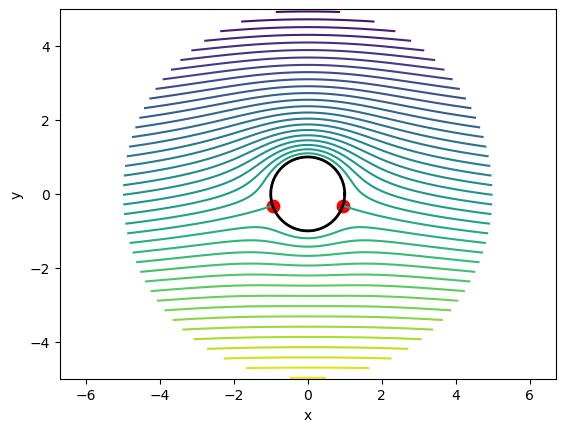

In [109]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.contour(mesh.X, mesh.Y, psi,40)
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)
if (np.abs(Gamma)>4*np.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*np.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*np.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*np.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-np.sqrt(R**2 - (Gamma / (4 * np.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * np.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='r', s=80, marker='o');
plt.show()

C:\Users\pschl\AppData\Local\Temp\ipykernel_17904\1542766605.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-4,cmap='jet')


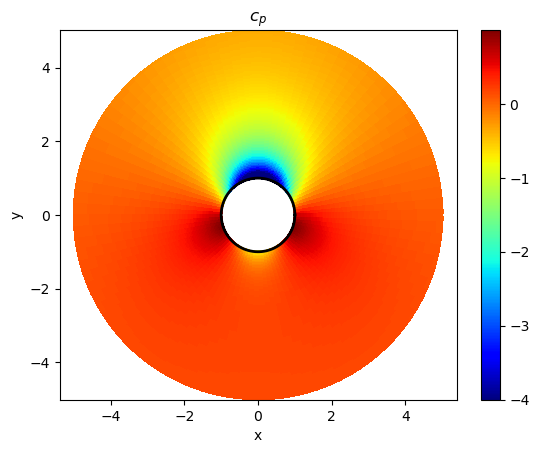

In [110]:
U.comp_p(u_inf)
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(mesh.X, mesh.Y, U.p/u_inf**2,vmin=-4,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)
plt.title('$c_p$')
plt.show()

Compute $ c_p= \frac{p-p_\infty}{\frac12  \rho U_\infty^2}$. The exact solution should be $c_p = 1-4\sin^2 \phi-\left( \frac{\Gamma}{2\pi U_\infty R}\right)^2 + \frac{2\Gamma \sin\theta}{\pi U_\infty R}$

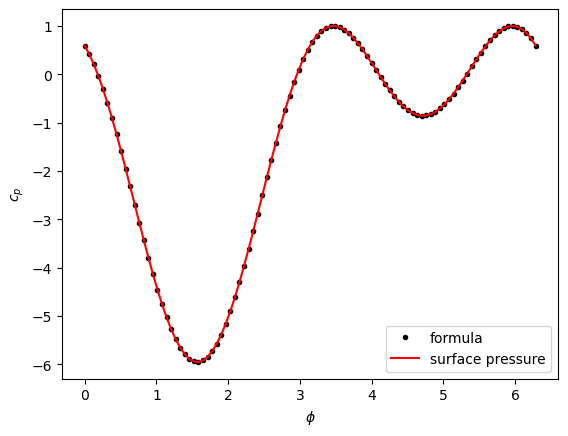

In [111]:
# compute $c_p$ as function of $\phi$, works only if you use the polar mesh
if mesh.type=="Polar":
    plt.figure()
    cp = U.p[:,0]/u_inf**2 ; phi = mesh.phi[:,0]
    cp_ex = 1-4*np.sin(phi)**2-(Gamma/(2*np.pi*u_inf*R))**2+2*Gamma*np.sin(phi)/(np.pi*u_inf*R)
    plt.plot(phi,cp_ex,'k.',label='formula')    
    plt.plot(phi,cp,'r',label='surface pressure')
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$c_p$')
    plt.legend()
    plt.show()
else:
    print("Only works for Polar meshes")

In [112]:
if mesh.type=="Polar":
    # Lift coefficient C_L using Kutta theorem
    C_L_kutta=2*Gamma/u_inf
    # Lift and drag using integration
    dphi = R*(phi[1]-phi[0])
    C_L=dphi*np.sum(cp[0:-1]*np.sin(phi[0:-1]))
    C_D=dphi*np.sum(cp[0:-1]*np.cos(phi[0:-1]))
    print('Lift using integration:  %0.3f   using Kutta theorem:  %0.3f ' % (C_L,C_L_kutta))
    print('Drag using integration:  %0.3f   ' % (C_D))
else:
    print("Only works for Polar meshes")

Lift using integration:  -8.000   using Kutta theorem:  -8.000 
Drag using integration:  0.000   
